In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
from jax import jit
import pennylane as qml
import optax
from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")
from scipy.special import comb

In [14]:
import pickle
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [15]:
n_qubits = 8
n_ancillas = 8

total_qubits = n_qubits + n_ancillas
dev = qml.device("default.qubit",wires=total_qubits)

  
#QCBM Circuit - RZ + IsingXY + IsingZZ    
def qcbm_circuit(params,total_qubits):
    
    rz_params = params[:total_qubits]
    ising_params = params[total_qubits:]
    for i in range(total_qubits):
        qml.RZ(rz_params[i],wires=i)
    for i in range(total_qubits-1):
        qml.IsingXY(ising_params[i],wires=[i,i+1])
    qml.IsingXY(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params[i],wires=[i,i+1])
    qml.IsingZZ(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    

@qml.qnode(dev, interface='jax')
def cat_circuit(input_params,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    #Random state for pretraining
    # uniform_init(num_qubits,distribution)
    qml.BasisState(jnp.zeros(total_qubits, dtype=jnp.int32), wires=list(range(total_qubits)))
    
    for i in range(total_qubits):
        if i%2 == 0:
            qml.X(i)
        
    for i in range(8):
        # qml.Barrier(range(total_qubits))
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)

    return qml.probs(wires=list(i for i in range(total_qubits) if i%2 == 0))

@qml.qnode(dev, interface='jax')
def anticat_circuit(input_params,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    #Random state for pretraining
    # uniform_init(num_qubits,distribution)
    qml.BasisState(jnp.zeros(total_qubits, dtype=jnp.int32), wires=list(range(total_qubits)))
    
    for i in range(total_qubits):
        if i%2 == 0:
            qml.X(i)
        
    for i in range(8):
        # qml.Barrier(range(total_qubits))
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)

    return qml.probs(wires=list(i for i in range(total_qubits) if i%2 != 0))


In [16]:
#Load the trained model

with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/anticat_model_distribution_copy.pkl',"rb") as file:
    trained_params = pickle.load(file)

parameters = trained_params['parameters']
kl_divs = trained_params['divs']

print("Model loaded successfully")

Model loaded successfully


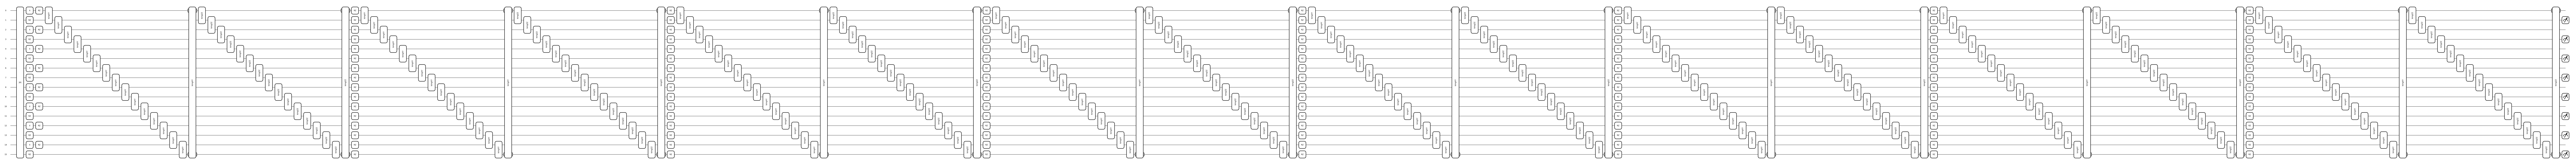

In [17]:
qml.draw_mpl(anticat_circuit,device='default')(parameters[0])
plt.show()

Text(0.5, 1.0, 'ANTI CAT')

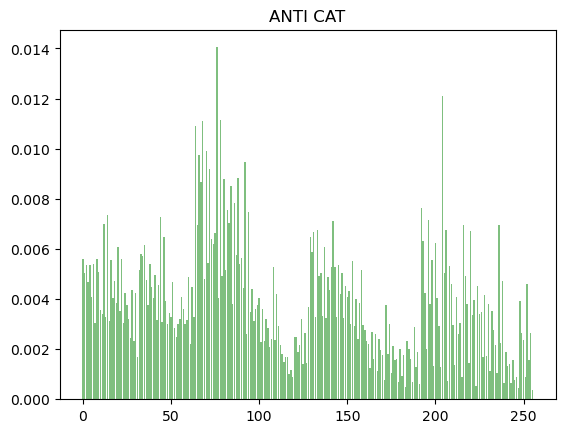

In [18]:
optimal_params = parameters[np.argmin(kl_divs)]

anti_cat = anticat_circuit(optimal_params)
x_array = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
plt.bar(x_array,anti_cat,color='green',alpha=0.5,label='obtained_distribution')
plt.title("ANTI CAT")

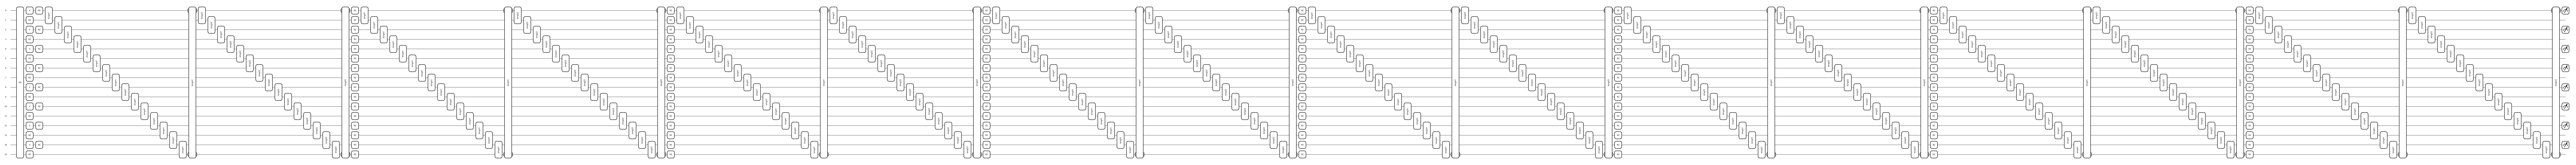

In [19]:
qml.draw_mpl(cat_circuit,device='default')(parameters[0])
plt.show()

Text(0.5, 1.0, 'CAT')

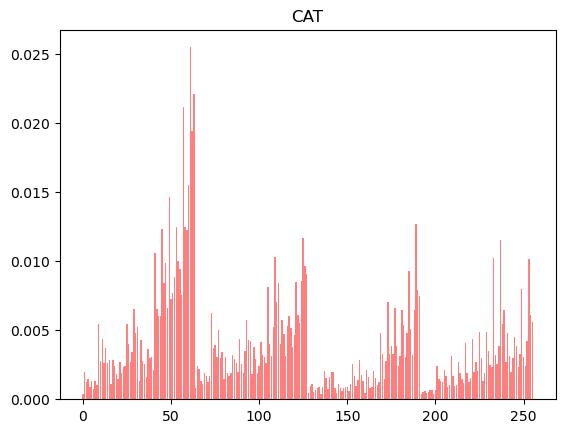

In [20]:
cat = cat_circuit(optimal_params)
plt.bar(x_array,cat,color='red',alpha=0.5,label='obtained_distribution')
plt.title("CAT")

In [21]:
#Loading the training data
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/anticat_distribution.pkl',"rb") as file:
    data = pickle.load(file)

target_distribution = data

In [22]:
kl_div1 = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(cat) - jnp.log(target_distribution)))
kl_div2 = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(anti_cat) - jnp.log(target_distribution)))
print(f"KL Divergence for CAT is {kl_div1} and KL Divergence for ANTI CAT is {kl_div2}")

KL Divergence for CAT is 0.683276891708374 and KL Divergence for ANTI CAT is 0.0020933847408741713


In [23]:
# Saving the AntiCat distribution
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/cat_distribution_copy.pkl',"wb") as file:
    pickle.dump(cat,file)

print("Cat distribution saved successfully")

Cat distribution saved successfully


In [24]:
#Loading the original cat training data
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/target_distribution.pkl',"rb") as file:
    data = pickle.load(file)

target_distribution = data

kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(cat) - jnp.log(target_distribution)))
print(f"KL Divergence for CAT w.r.t original CAT is {kl_div}")

KL Divergence for CAT w.r.t original CAT is 0.1887126863002777
